In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
!pip install pickle5
import pickle5 as pickle
import pprint

import gensim.models

from sklearn.manifold import TSNE

plt.style.use('ggplot')

In [ ]:
data = pickle.load(open("/content/right_data.pickle", "rb"))


In [ ]:
def last_preprocess(table_name):
    
    table_name = table_name[table_name['body'].notnull()]
    
    # Turning each comment into a vector of words
    table_name['body'] = table_name['body'].apply(lambda x: x.split(' '))

    # Removing single letter words for this context
    table_name['body'] = table_name['body'].apply(lambda x: [word for word in x if len(word)>1])
    
    return table_name

In [ ]:
right_names = []

for key, _ in data.items():
  right_names.append(key)

right_names

['conservative0',
 'conservative1',
 'conservative2',
 'conservative4',
 'conservative5',
 'republican0',
 'republican1',
 'republican2',
 'republican3',
 'republican4',
 'republican5']

In [ ]:
for i in right_names:
  data[i] = last_preprocess(data[i])


In [ ]:
conservative = pd.concat([data['conservative0'], data['conservative1'], data['conservative2'],
                          data['conservative4'], data['conservative5']])
conservative

,body
0,"[populism, be, not, about, philosophy, or, pri..."
1,"[dude, he, be, lie, he, do, this, kind, of, th..."
2,"[look, who, saw, gasland, and, be, really, ang..."
3,"[someone, do, not, understand, the, concept, o..."
4,"[nothing, prevents, individual, from, share, t..."
...,...
24469,"[be, wait, for, them, to, go, to, laugh, track..."
24470,"[canadian, lol, until, stop, see, lb, people, ..."
24471,"[think, that, be, cnn, business, model, they, ..."
24472,"[or, they, do, get, it, and, they, do, not, ca..."


In [ ]:
republican = pd.concat([data['republican0'], data['republican1'], data['republican2'],
                        data['republican3'], data['republican4'], data['republican5']])

republican

,body
1,"[vaccine, because, autism]"
2,"[horrify, it, may, seem, clinton, be, likely, ..."
3,"[be, democrat, and, dis, union, too, in, their..."
4,"[will, freely, admit, that, union, be, necessa..."
6,"[vote, on, principle, such, there, be, no, cir..."
...,...
2760,"[actually, that, would, be, good, advice, for,..."
2761,"[would, love, nothing, more]"
2762,"[what, make, you, think, he, have, desire, to,..."
2763,"[it, be, good, point, but, the, thing, be, one..."


In [ ]:
# Conservative dataframe
conservative_cbow = gensim.models.Word2Vec(sentences=conservative['body'], size=50, window = 5, min_count = 5, workers = 10, sg = 0)

conservative_sg = gensim.models.Word2Vec(sentences=conservative['body'], size=50, window = 5, min_count = 5, workers = 10, sg = 1)


# Republican dataframe
republican_cbow = gensim.models.Word2Vec(sentences=republican['body'], size=50, window = 5, min_count = 5, workers = 10, sg = 0)

republican_sg = gensim.models.Word2Vec(sentences=republican['body'], size=50, window = 5, min_count = 5, workers = 10, sg = 1)


In [ ]:
words = ['word', 'freedom', 'trust', 'radical', 'democracy', 'privacy', 'safety',
         'right','police','healthcare','government','restriction','accountability',
         'correct','political','cancel','culture','constitution','conventional',
         'authoritarian','tradition','leadership']

In [ ]:
def similar_df(cbow_model, sg_model, word_list):

  import pandas as pd

  vocab_cbow = {}
  vocab_sg = {}

  for _ in word_list:
      vocab_cbow[_] = cbow_model.most_similar(_)
      vocab_sg[_] = sg_model.most_similar(_)

  similar_cbow = {}
  similar_sg = {}

  for i in word_list:
    similar_cbow[f'{i}'] = [vocab_cbow[i][j][0] for j in range(len(vocab_cbow[i]))]
    similar_sg[f'{i}'] = [vocab_sg[i][j][0] for j in range(len(vocab_sg[i]))]

  return pd.DataFrame(data = similar_cbow), pd.DataFrame(data = similar_sg)

In [ ]:
conservative_cbow_df, conservative_sg_df = similar_df(conservative_cbow, conservative_sg, words)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
republican_cbow_df, republican_sg_df = similar_df(republican_cbow, republican_sg, words)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
conservative_cbow_df.to_excel('conservative_cbow_df.xlsx')
conservative_sg_df.to_excel('conservative_sg_df.xlsx')

republican_cbow_df.to_excel('republican_cbow_df.xlsx')
republican_sg_df.to_excel('republican_sg_df.xlsx')


In [ ]:
def tsne_plot(model, vocab):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=0)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    fig, axs = plt.subplots(figsize=(8,8))
    axs.set_title('Word Clusters')
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
    plt.show()

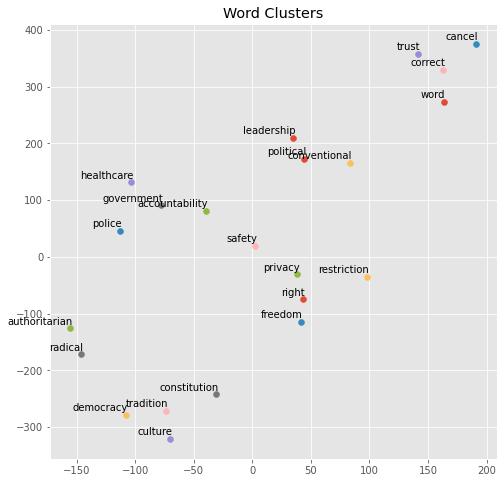

In [ ]:
tsne_plot(conservative_sg, words)

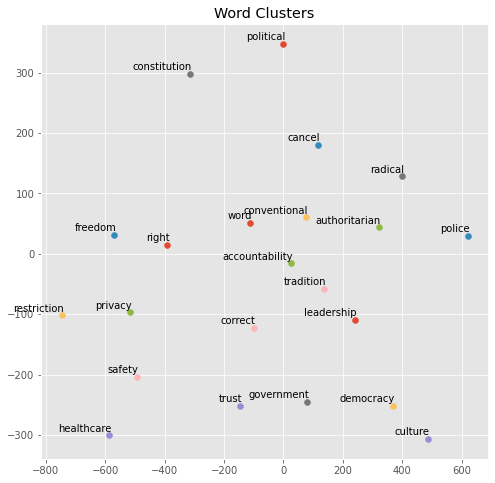

In [ ]:
tsne_plot(republican_sg, words)

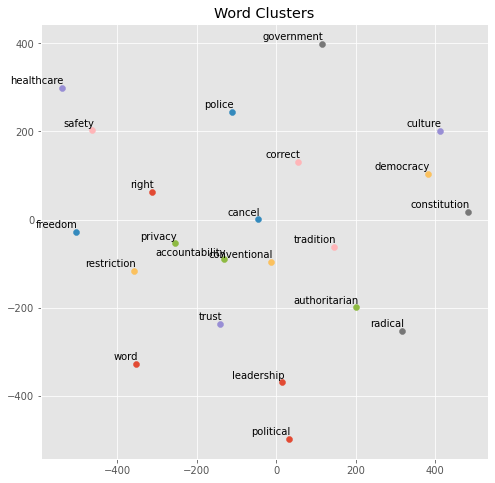

In [ ]:
tsne_plot(conservative_cbow, words)

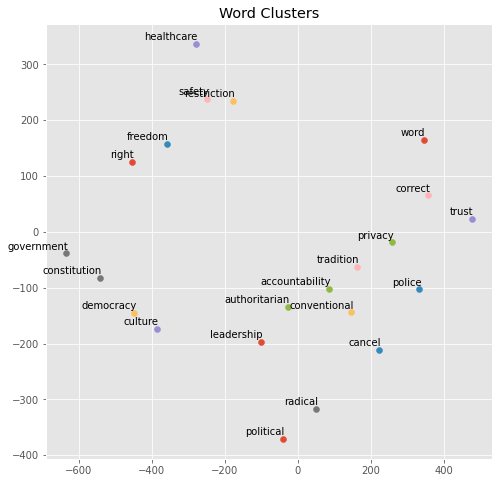

In [ ]:
tsne_plot(republican_cbow, words)